In [1]:
# импорт библиотек
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

### Задание 1: Классификация. Логистическая регрессия и SVM
* подготовка данных
    * проверка на пропуски данных (в случае обнаружения предложить альтернативный способ)
    * построение графиков (1, 2 => отобразить особенность `dataset`)
    * преобразовать категориальные признаки
    * разделение выборки 80/20
* обучение моделей
    * __обучить модель `логистической регрессии`__
    * __обучить модель `опорных векторов`__
* оценка точности моделей
    * __рассчитать точность предсказания `score`__
* выводы по работе
    * сравнение точностей двух моделей
    * вывод

#### Загрузка данных, оценка и подготовка данных

In [2]:
# загрузка данных
df = pd.read_csv('../src/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


#### Проверка и удаление пропусков и не понятных значений

In [3]:
# замена не известных значений ан пустые и их удаление
# df.eq('?').sum()
# df = df.replace('?',np.nan)
# df = df.dropna()

In [4]:
# проверка пропусков значений
if df.isnull().sum().sum() != 0:
    raise Exception('dataset содержит пустые значения')
elif 1> df['age'].min() > 100:
    print("Вероятно мусор в данных")
else:
    print('dataset не содержит пустых значений')

dataset не содержит пустых значений


#### Оценка датасета и построение графиков

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
educational-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [6]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


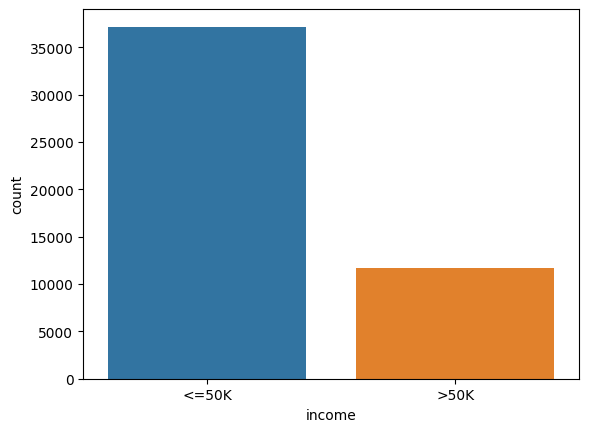

In [7]:
sns.countplot(x="income",data=df)
plt.show()

<Figure size 800x640 with 0 Axes>

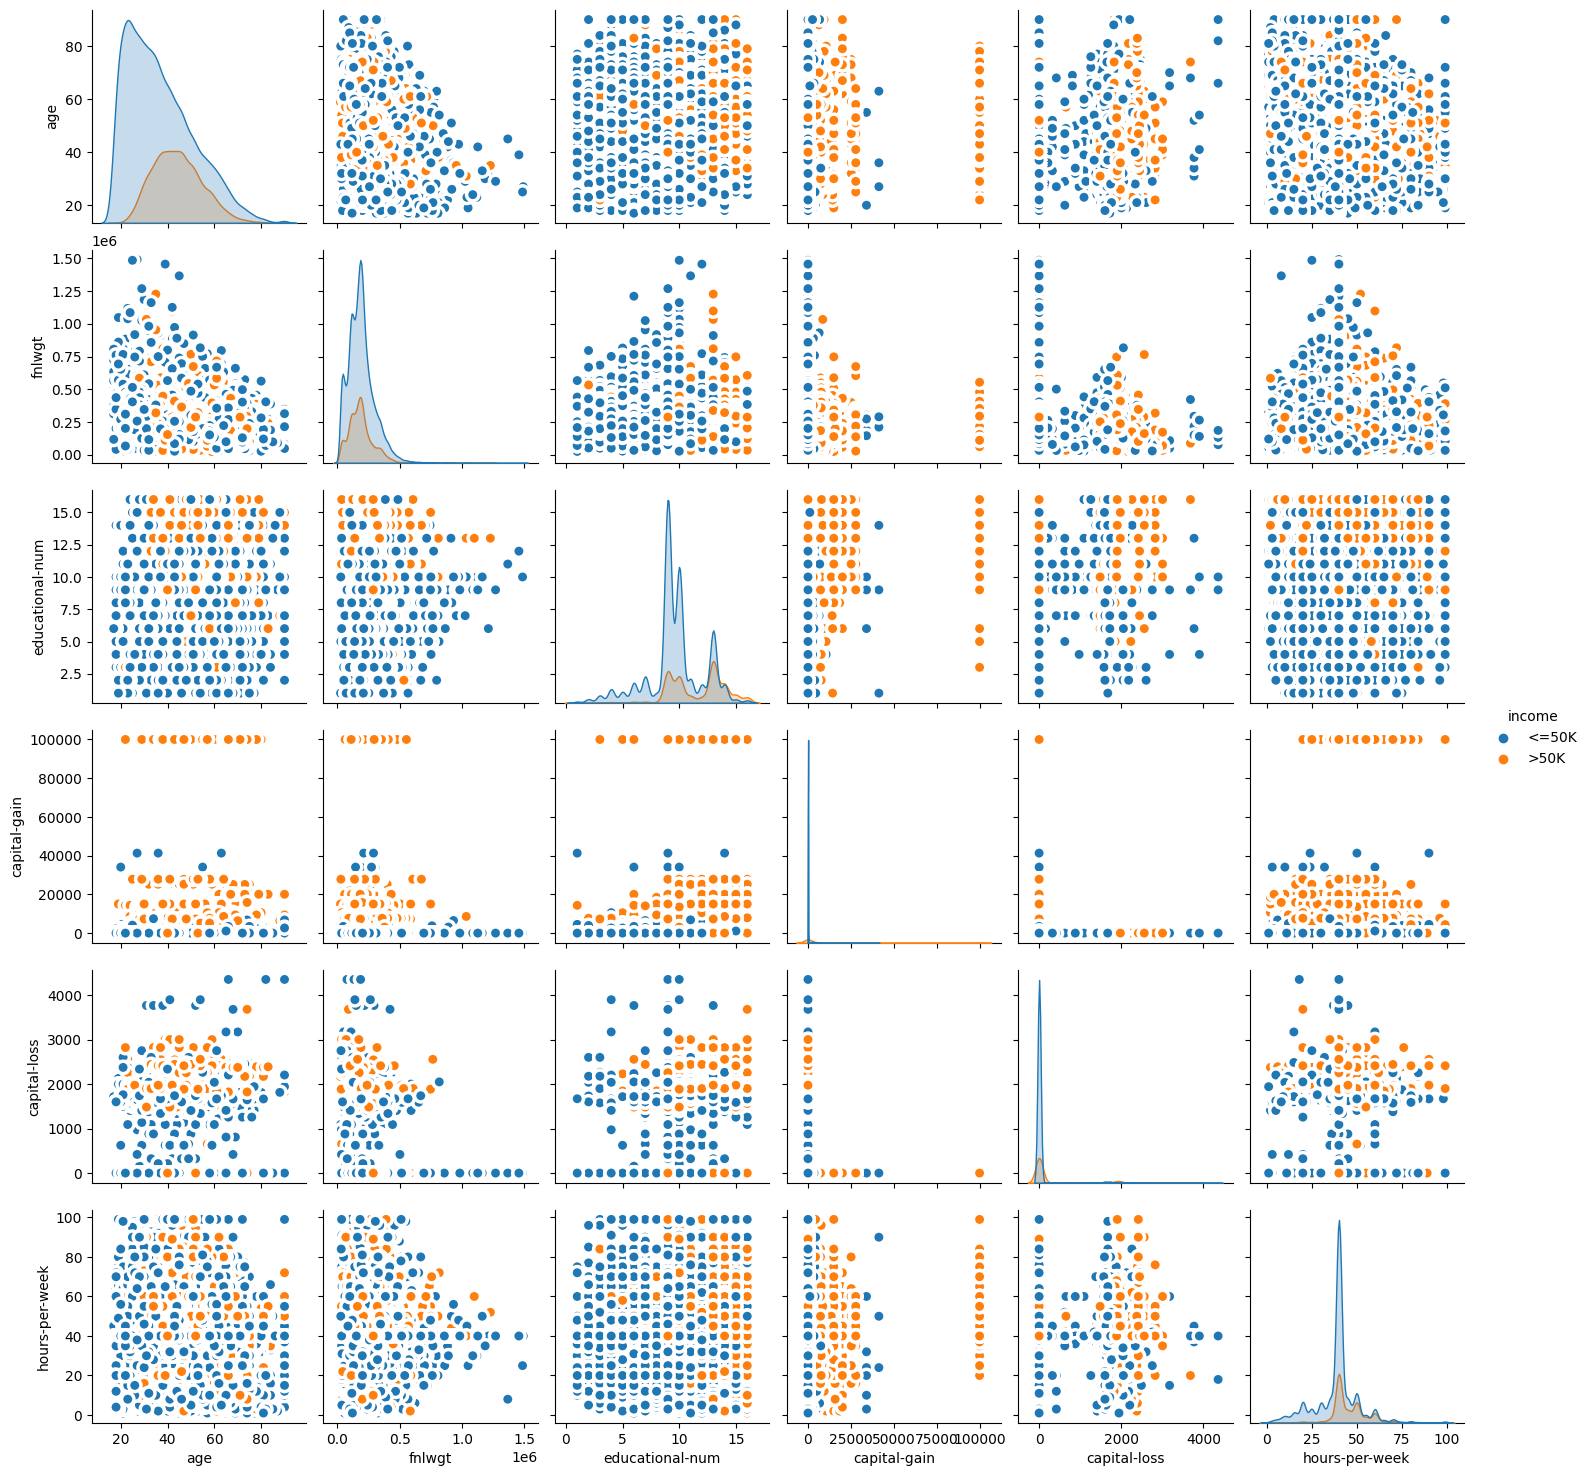

In [8]:
# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="scatter", hue="income", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

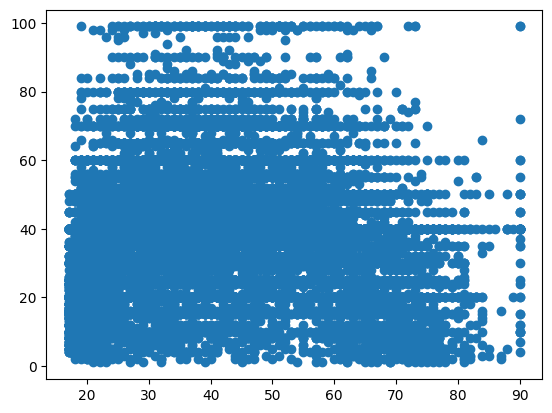

In [9]:
plt.scatter(x=df[['age']], y=df[['hours-per-week']])
plt.show()

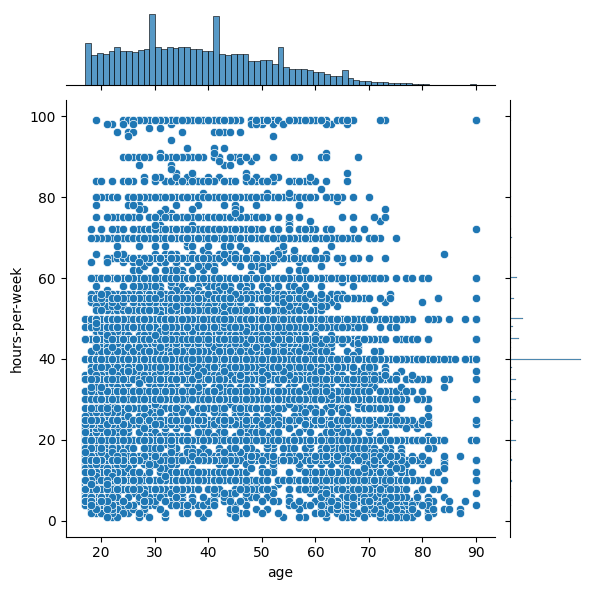

In [11]:
sns.jointplot(data=df, x="age", y="hours-per-week")

Text(0.5, 1.0, 'доход 50,000 и менее')

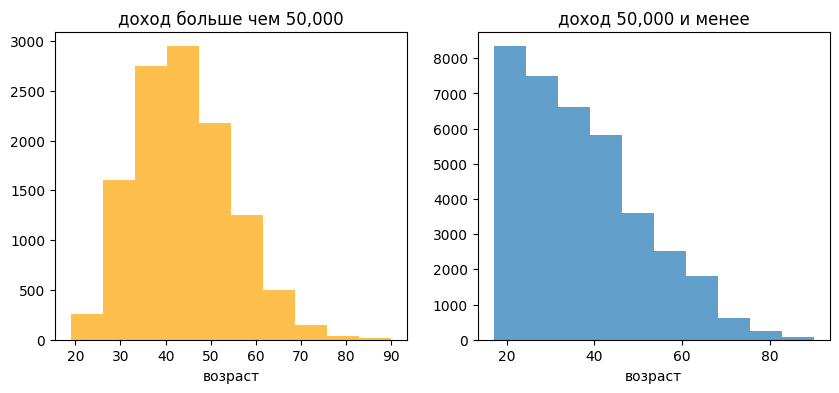

In [12]:
figure, axis = plt.subplots(1, 2, figsize=(10,4))

axis[0].hist(df[df['income'] == '>50K']['age'], bins=10, color='orange', alpha=0.7)
axis[0].set_xlabel('возраст')
axis[0].set_title('доход больше чем 50,000')

axis[1].hist(df[df['income'] == '<=50K']['age'], bins=10, alpha=0.7)
axis[1].set_xlabel('возраст')
axis[1].set_title('доход 50,000 и менее')

#### Преобразование категориальных переменных

In [14]:
X = pd.get_dummies(df,\
        columns=[
            'workclass',
            'education',
            'marital-status',
            'occupation',
            'relationship',
            'race',
            'gender',
            'native-country'
        ], dtype=int)

In [15]:
X.head()
del X['income']

#### Преобразование целевого значение в бинарный вид

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [17]:
le.fit(df['income'])
y = pd.Series(data=le.transform(df['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int32

#### Обучение_1 модели Линейной регрессии
+ сборка `pipeline`
+ масштабирование данных **Стандартизация** - StandardScaler()
+ выборка `20 / 80`

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# обучаем на части датасета (train)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
model.predict_proba(X_test) # для получения вероятности отнесения к определенной категории

array([[0.98716194, 0.01283806],
       [0.90009464, 0.09990536],
       [0.06605029, 0.93394971],
       ...,
       [0.42400445, 0.57599555],
       [0.99749396, 0.00250604],
       [0.26775599, 0.73224401]])

#### SCORE_1 Линейной регрессии

In [22]:
f"score: {model.score(X_train, y_train)} score на тестовом массиве: {model.score(X_test, y_test)}"

'score: 0.8529163360888593 score на тестовом массиве: 0.8574060804585935'

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model.predict(X_test))

0.8574060804585935

#### Обучение_2 метод опорных векторов. SVM.
+ сборка `pipeline`
+ масштабирование данных **Стандартизация** - StandardScaler()
+ выборка `20 / 80`

In [24]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC()) 
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

#### SCORE_2_0 метод опорных векторов. SVM с использованием `StandardScaler`

In [25]:
f"score: {clf.score(X_train, y_train)} score на тестовом массиве: {clf.score(X_test, y_test)}"

'score: 0.8616691833235226 score на тестовом массиве: 0.8540280479066434'

#### SCORE_2_1 метод опорных векторов. SVM без использования `StandardScaler`

In [26]:
svc = SVC()
svc.fit(X_train, y_train)
f"score: {svc.score(X_train, y_train)} score на тестовом массиве: {svc.score(X_test, y_test)}"

'score: 0.7967650295600542 score на тестовом массиве: 0.8033575596273927'

###

### Выводы
+ `score` Линейной регрессии `0.8574` при этом`score` SVM `0.854`
+ но потребление ресурсов в методе SVM значительно выше в разы !!!
+ `score` SVM хуже без масштабирования `score` `0.8033`